In [3]:
# Support for math
import numpy as np
import math

# Plotting tools
from matplotlib import pyplot as plt
import matplotlib
from matplotlib import cm
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import warnings
warnings.filterwarnings('ignore')

# File Tools for local
import pandas as pd
import sys

# Random seed for reproducibility
import random

import torch
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils.transforms import normalize, unnormalize

from ipywidgets import interact, FloatSlider

#LHS sampling
#from pyDOE import lhs
from smt.sampling_methods import LHS
import random

# Cluster 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


>## Data Prep

In [4]:
df = pd.read_csv('parameterspace.csv')
df

,n,theta,r,t,toughness,mass,printerid,campaignid,category
0,6,0,1.5,0.70,1.144667,1.7131,1,1,2
1,6,0,1.5,1.05,1.607561,1.9386,2,1,2
2,6,0,1.5,1.40,1.144338,1.9828,3,1,2
3,6,0,1.7,0.70,3.642738,1.9723,4,1,2
4,6,0,1.7,1.05,3.748405,2.2785,5,1,2
...,...,...,...,...,...,...,...,...,...
1795,12,200,2.3,1.05,1.358975,6.3430,5,3,3
1796,12,200,2.3,1.40,3.196306,5.7742,1,3,3
1797,12,200,2.5,0.70,36.104187,4.8745,2,3,3
1798,12,200,2.5,1.05,1.313487,6.7221,4,3,3


In [5]:
# Cross-barrel 3D printing parameters and thier mechanical properties
columns = ['n',	'theta','r','t','toughness']
all_data = pd.read_csv('parameterspace.csv')[columns]

# Group by the specified columns and calculate stats
grouped = all_data.groupby(['n', 'theta', 'r', 't']).agg(
    toughness_mean=('toughness', 'mean'),
    toughness_variance=('toughness', 'var'),
    count=('toughness', 'count')
).reset_index()

# Keep only groups where count > 1 (i.e., duplicates)
train_data = grouped[grouped['count'] > 1]

# print(train_data.head())

x_inputs = train_data[["n", "theta", "r", "t"]]
y_outputs = train_data["toughness_mean"]
yvar_outputs = train_data["toughness_variance"]
# Set the device and dtype
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
# Convert to torch tensors
x_all = torch.tensor(x_inputs.to_numpy(), dtype=torch.float32)
y_all = torch.tensor(y_outputs.values.reshape(-1, 1), dtype=torch.float32)
yvar_all = torch.tensor(yvar_outputs.values.reshape(-1, 1), dtype=torch.float32)


# Define a ground truth 
def ground_truth(x_query_batch: torch.Tensor):
    """
    x_query_batch: Tensor of shape (batch_size, d)
    Returns: Tensor of shape (batch_size, 1)
    """
    # x_all should be of shape (N, d)
    # Expand for broadcasting: (batch_size, N, d)
    diffs = x_all.unsqueeze(0) - x_query_batch.unsqueeze(1)  # (batch, N, d)
    dists = torch.norm(diffs, dim=2)  # (batch, N)
    idx = torch.argmin(dists, dim=1)  # (batch,)
    return y_all[idx]  # (batch, 1)



In [6]:
import plotly.express as px

# Create subplots
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Scatter of (n, t, r)", "Scatter of (n, theta, r)", "Scatter of (n, t, theta)")
)

# Scatter of (n, t, r)
scatter1 = go.Scatter3d(
    x=df['n'],
    y=df['t'],
    z=df['r'],
    mode='markers',
    marker=dict(size=10, color=df['toughness'], colorscale='viridis', colorbar=dict(title="Toughness")),
    name="(n, t, r)"
)
fig.add_trace(scatter1, row=1, col=1)

# Scatter of (n, theta, r)
scatter2 = go.Scatter3d(
    x=df['n'],
    y=df['theta'],
    z=df['r'],
    mode='markers',
    marker=dict(size=10, color=df['toughness'], colorscale='viridis', colorbar=dict(title="Toughness")),
    name="(n, theta, r)"
)
fig.add_trace(scatter2, row=1, col=2)

# Scatter of (n, t, theta)
scatter3 = go.Scatter3d(
    x=df['n'],
    y=df['t'],
    z=df['theta'],
    mode='markers',
    marker=dict(size=10, color=df['toughness'], colorscale='viridis', colorbar=dict(title="Toughness")),
    name="(n, t, theta)"
)
fig.add_trace(scatter3, row=1, col=3)

# Update layout
fig.update_layout(
    title_text="3D Scatter Subplots",
    height=600,
    showlegend=False
)

# Show the plot
fig.show()



In [7]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

## Build Model A class 
class GaussianProcessModel:
    def __init__(self, x_train, y_train, yvar_train, bounds):
        self.x_train = x_train
        self.y_train = y_train
        self.yvar_train = yvar_train
        self.bounds = bounds
        self.model = self._fit_gp_model()
    
    def _fit_gp_model(self):
        model = SingleTaskGP(self.x_train, self.y_train, self.yvar_train)
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)
        return model

    def gp_evaluate(self, test_x):
        self.model.eval()
        with torch.no_grad():
            posterior = self.model.posterior(test_x)
        mean = posterior.mean.squeeze().numpy()
        var = posterior.variance.squeeze().numpy()
        return mean, var
    


In [8]:
class Plotting:
    def __init__(self, gp_model:GaussianProcessModel, variable_combinations):
        self.gp_model = gp_model
        self.x_train = gp_model.x_train
        self.y_train = gp_model.y_train
        self.bounds = gp_model.bounds
        self.variable_combinations = variable_combinations
        self.dtype = dtype

    def generate_input_data(self, A, B, c, d, combination):
        if combination == ('n', 'r', 't'):
            return torch.tensor(np.array([[A[i, j], d, B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)
        elif combination == ('theta', 'r', 't'):
            return torch.tensor(np.array([[d, A[i, j], B[i, j], c] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)
        elif combination == ('n', 't', 'theta'):
            return torch.tensor(np.array([[A[i, j], c, B[i, j], d] for i in range(A.shape[0]) for j in range(A.shape[1])]), dtype=self.dtype)

    def create_slices(self, c_slices, d_fixed, combination):
        num_points = 20
        a = np.linspace(0, 1, num_points)
        b = np.linspace(0, 1, num_points)
        A, B = np.meshgrid(a, b)

        store_mean = []
        for d in d_fixed:
            mean_values = []
            for c in c_slices:
                input_data = self.generate_input_data(A, B, c, d, combination)
                mean, _ = self.gp_model.gp_evaluate(input_data)
                mean_values.append(mean.reshape(A.shape))  # Reshape to grid
            store_mean.append(mean_values)

        return A, B, store_mean
    

    def sliced_plotting(self, combination, minmax, colormap='Viridis'):
        # Create slices for the fixed variable
        c_slices = np.linspace(0, 1, 8)
        d_fixed = [0, 0.25, 0.5, 0.75, 1.0]  # Fixed value for the other variable

        # Create a new figure with subplots for each combination
        fig = make_subplots(rows=1, cols=5, subplot_titles=('theta: 0', 'theta: 0.25','theta: 0.5', 'theta: 0.75','theta: 1.0'),
                        specs=[[{'type': 'surface'}, {'type': 'surface'},{'type': 'surface'}, {'type': 'surface'}, {'type': 'surface'}]])
        global_min = minmax[0].item()
        global_max = minmax[1].item()

        # Create slices and get mean values
        A, B, store_mean = self.create_slices(c_slices, d_fixed, combination)
        # Unpack the mean values for each slice
        mean_vals1, mean_vals2, mean_vals3, mean_vals4, mean_vals5 = store_mean[0], store_mean[1], store_mean[2], store_mean[3], store_mean[4]  

        for i, (c, y_grid1, y_grid2, y_grid3, y_grid4, y_grid5) in enumerate(zip(c_slices, mean_vals1,mean_vals2,mean_vals3,mean_vals4,mean_vals5), start=1):
            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid1,  # Use predicted `y` as contour
                colorscale=colormap,
                cmin=global_min,
                cmax=global_max,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                #   colorbar_x=0.45,
                opacity=0.7
            ), row=1, col=1)
    
            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid2,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                #colorbar_x=0.45,
                opacity=0.7
            ), row=1, col=2)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid3,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=3)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid4,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=4)

            fig.add_trace(go.Surface(
                x=A,
                y=B,
                z=c * np.ones_like(A),  # Z-coordinate for slicing
                surfacecolor=y_grid5,  # Use predictediance as contour
                cmin=global_min,
                cmax=global_max,
                colorscale=colormap,
                showscale=True if i == 1 else False,  # Show color scale only on the first slice
                opacity=0.7
            ), row=1, col=5)
            
        fig.update_layout(
            height=400,
            width=1300,
            margin=dict(l=50, r=50, b=50, t=50),
            scene=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene2=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene3=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene4=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            ),
            scene5=dict(
                xaxis_title=combination[0],
                yaxis_title=combination[1],
                zaxis_title=combination[2]
            )
        )

        fig.show()



In [9]:
# 1. Define the bounds for the GP model
dtype = torch.float32
original_bounds = torch.tensor([[x_all[:,0].min(), x_all[:,1].min(), x_all[:,2].min(), x_all[:,3].min()], [x_all[:,0].max(), x_all[:,1].max(), x_all[:,2].max(), x_all[:,3].max()]])
nx_all = normalize(x_all, bounds=original_bounds)
# 2. Create the GP model
gp_model = GaussianProcessModel(x_train = nx_all, y_train = y_all, yvar_train=yvar_all, bounds=original_bounds)

# 3. Define your slicing combination
variable_combinations = [('n', 'r', 't')]#('theta', 'r', 't'), ('n', 't', 'theta')

# 4. Instantiate the plotting utility
plotter = Plotting(gp_model, variable_combinations)

# 5. Define min/max range for colorbar
minmax = [torch.min(y_all), torch.max(y_all)]

# 6. Plot!
plotter.sliced_plotting(variable_combinations[0], minmax)

  0%|          | 0/600 [00:00<?, ?it/s]

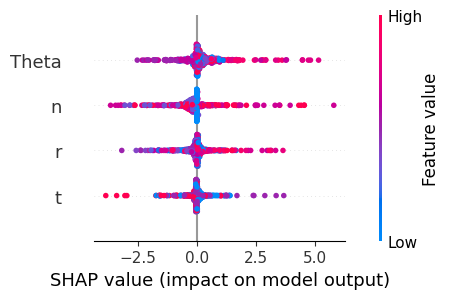

In [10]:
# add shap 
import shap
from sklearn.preprocessing import StandardScaler

# Step 1: Fit the GP model
gp_full = gp_model.model

# Step 2: Prepare the prediction wrapper for SHAP
def gp_predict(X_scaled_np):
    X_scaled_torch = torch.tensor(X_scaled_np, dtype=torch.float32)
    gp_full.eval()
    with torch.no_grad():
        posterior = gp_full.posterior(X_scaled_torch)
    return posterior.mean.squeeze(-1).numpy()

# Step 3: Normalize the inputs
scaler = StandardScaler()
x_all_np = x_all .numpy()
x_all_scaled = scaler.fit_transform(x_all_np)

# Step 4: Run SHAP (KernelExplainer)
explainer = shap.KernelExplainer(gp_predict, x_all_scaled[:100])  # background dataset
shap_values = explainer.shap_values(x_all_scaled)

# Step 5: Plot SHAP summary
# Create a matplotlib figure with square aspect ratio
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 8))
shap.summary_plot(shap_values, x_all_scaled, feature_names=["n", "Theta", "r", "t"], show=False)
plt.gca().set_box_aspect(0.9)
plt.show()


